# Distracted Driver Detection

## Goal

Classify driver behaviors using supervised and deep learning methods in order to prevent distracted driving incidents

## Dataset

[State Farm Distracted Driver Detection Dataset](https://www.kaggle.com/competitions/state-farm-distracted-driver-detection/data) isused for Distracted Driver Detection. The dataset consists of labelled photos of drivers taken inside the car.Dataset has ten different types of driver behaviours, including safe driving and various forms of distracted driving. These graphics depict ten different types of driver behaviours, including safe driving and various forms of distracted driving, such as texting, chatting on the phone, eating, and reaching behind.





### Import Packages

In [1]:
import os
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns 
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.image as mpimg
from glob import glob
from tqdm import tqdm
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split  
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model,Sequential
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [2]:

os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
dataset = pd.read_csv('driver_imgs_list.csv')
dataset.head(5)

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

### Preprocessing Data

In [4]:
NUMBER_CLASSES = 10
# Color type: 1 - grey, 3 - rgb

def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

# Training
def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join( 'imgs','train', 'c' + str(classed), '*.jpg'))
        print("*******files:",files)
        for file in files:
            print("-------",file)
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Validation
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join( 'imgs','test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

In [5]:
img_rows = 64
img_cols = 64
color_type = 1

In [6]:
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0
*******files: ['imgs\\train\\c0\\img_100026.jpg', 'imgs\\train\\c0\\img_10003.jpg', 'imgs\\train\\c0\\img_100050.jpg', 'imgs\\train\\c0\\img_100074.jpg', 'imgs\\train\\c0\\img_10012.jpg', 'imgs\\train\\c0\\img_100145.jpg', 'imgs\\train\\c0\\img_100191.jpg', 'imgs\\train\\c0\\img_100257.jpg', 'imgs\\train\\c0\\img_100312.jpg', 'imgs\\train\\c0\\img_100337.jpg', 'imgs\\train\\c0\\img_100456.jpg', 'imgs\\train\\c0\\img_1005.jpg', 'imgs\\train\\c0\\img_10053.jpg', 'imgs\\train\\c0\\img_100542.jpg', 'imgs\\train\\c0\\img_100598.jpg', 'imgs\\train\\c0\\img_100605.jpg', 'imgs\\train\\c0\\img_100656.jpg', 'imgs\\train\\c0\\img_100665.jpg', 'imgs\\train\\c0\\img_100796.jpg', 'imgs\\train\\c0\\img_100824.jpg', 'imgs\\train\\c0\\img_100828.jpg', 'imgs\\train\\c0\\img_10092.jpg', 'imgs\\train\\c0\\img_100922.jpg', 'imgs\\train\\c0\\img_101015.jpg', 'imgs\\train\\c0\\img_101032.jpg', 'imgs\\train\\c0\\img_101091.jpg', 'imgs\\train\\c0\\img_101113.jpg', 'imgs\\train\\c0\\img_101

 10%|█         | 1/10 [00:36<05:27, 36.35s/it]

------- imgs\train\c0\img_99515.jpg
------- imgs\train\c0\img_99527.jpg
------- imgs\train\c0\img_99635.jpg
------- imgs\train\c0\img_99640.jpg
------- imgs\train\c0\img_99651.jpg
------- imgs\train\c0\img_99652.jpg
------- imgs\train\c0\img_9967.jpg
------- imgs\train\c0\img_99696.jpg
------- imgs\train\c0\img_99715.jpg
------- imgs\train\c0\img_99779.jpg
------- imgs\train\c0\img_99785.jpg
------- imgs\train\c0\img_99846.jpg
------- imgs\train\c0\img_99971.jpg
Loading directory c1
*******files: ['imgs\\train\\c1\\img_100021.jpg', 'imgs\\train\\c1\\img_100045.jpg', 'imgs\\train\\c1\\img_100046.jpg', 'imgs\\train\\c1\\img_10011.jpg', 'imgs\\train\\c1\\img_100126.jpg', 'imgs\\train\\c1\\img_100135.jpg', 'imgs\\train\\c1\\img_100153.jpg', 'imgs\\train\\c1\\img_100155.jpg', 'imgs\\train\\c1\\img_100230.jpg', 'imgs\\train\\c1\\img_100348.jpg', 'imgs\\train\\c1\\img_100358.jpg', 'imgs\\train\\c1\\img_100365.jpg', 'imgs\\train\\c1\\img_100375.jpg', 'imgs\\train\\c1\\img_100399.jpg', 'imgs\\t

 20%|██        | 2/10 [01:08<04:30, 33.81s/it]

------- imgs\train\c1\img_99979.jpg
Loading directory c2
*******files: ['imgs\\train\\c2\\img_100029.jpg', 'imgs\\train\\c2\\img_100108.jpg', 'imgs\\train\\c2\\img_100113.jpg', 'imgs\\train\\c2\\img_100168.jpg', 'imgs\\train\\c2\\img_100176.jpg', 'imgs\\train\\c2\\img_100242.jpg', 'imgs\\train\\c2\\img_100246.jpg', 'imgs\\train\\c2\\img_100458.jpg', 'imgs\\train\\c2\\img_100471.jpg', 'imgs\\train\\c2\\img_10048.jpg', 'imgs\\train\\c2\\img_100493.jpg', 'imgs\\train\\c2\\img_100502.jpg', 'imgs\\train\\c2\\img_100514.jpg', 'imgs\\train\\c2\\img_100627.jpg', 'imgs\\train\\c2\\img_100646.jpg', 'imgs\\train\\c2\\img_100682.jpg', 'imgs\\train\\c2\\img_100738.jpg', 'imgs\\train\\c2\\img_100762.jpg', 'imgs\\train\\c2\\img_100784.jpg', 'imgs\\train\\c2\\img_100813.jpg', 'imgs\\train\\c2\\img_100897.jpg', 'imgs\\train\\c2\\img_101016.jpg', 'imgs\\train\\c2\\img_101068.jpg', 'imgs\\train\\c2\\img_10108.jpg', 'imgs\\train\\c2\\img_101086.jpg', 'imgs\\train\\c2\\img_101097.jpg', 'imgs\\train\\c2\\im

 30%|███       | 3/10 [01:40<03:52, 33.21s/it]

------- imgs\train\c2\img_99824.jpg
------- imgs\train\c2\img_9983.jpg
------- imgs\train\c2\img_9986.jpg
Loading directory c3
*******files: ['imgs\\train\\c3\\img_100006.jpg', 'imgs\\train\\c3\\img_100041.jpg', 'imgs\\train\\c3\\img_100048.jpg', 'imgs\\train\\c3\\img_100139.jpg', 'imgs\\train\\c3\\img_100281.jpg', 'imgs\\train\\c3\\img_100328.jpg', 'imgs\\train\\c3\\img_100339.jpg', 'imgs\\train\\c3\\img_10034.jpg', 'imgs\\train\\c3\\img_100374.jpg', 'imgs\\train\\c3\\img_100412.jpg', 'imgs\\train\\c3\\img_100414.jpg', 'imgs\\train\\c3\\img_100419.jpg', 'imgs\\train\\c3\\img_100423.jpg', 'imgs\\train\\c3\\img_100503.jpg', 'imgs\\train\\c3\\img_100545.jpg', 'imgs\\train\\c3\\img_100611.jpg', 'imgs\\train\\c3\\img_10062.jpg', 'imgs\\train\\c3\\img_10068.jpg', 'imgs\\train\\c3\\img_100691.jpg', 'imgs\\train\\c3\\img_100701.jpg', 'imgs\\train\\c3\\img_100749.jpg', 'imgs\\train\\c3\\img_100818.jpg', 'imgs\\train\\c3\\img_100838.jpg', 'imgs\\train\\c3\\img_100872.jpg', 'imgs\\train\\c3\\img

 40%|████      | 4/10 [02:14<03:20, 33.40s/it]

------- imgs\train\c3\img_99703.jpg
------- imgs\train\c3\img_99712.jpg
------- imgs\train\c3\img_99727.jpg
------- imgs\train\c3\img_99754.jpg
------- imgs\train\c3\img_99813.jpg
------- imgs\train\c3\img_99848.jpg
------- imgs\train\c3\img_99870.jpg
------- imgs\train\c3\img_99896.jpg
------- imgs\train\c3\img_99906.jpg
------- imgs\train\c3\img_99947.jpg
------- imgs\train\c3\img_99963.jpg
Loading directory c4
*******files: ['imgs\\train\\c4\\img_100225.jpg', 'imgs\\train\\c4\\img_10025.jpg', 'imgs\\train\\c4\\img_100277.jpg', 'imgs\\train\\c4\\img_100297.jpg', 'imgs\\train\\c4\\img_100343.jpg', 'imgs\\train\\c4\\img_100361.jpg', 'imgs\\train\\c4\\img_100371.jpg', 'imgs\\train\\c4\\img_100452.jpg', 'imgs\\train\\c4\\img_10050.jpg', 'imgs\\train\\c4\\img_100529.jpg', 'imgs\\train\\c4\\img_100530.jpg', 'imgs\\train\\c4\\img_100561.jpg', 'imgs\\train\\c4\\img_100778.jpg', 'imgs\\train\\c4\\img_10078.jpg', 'imgs\\train\\c4\\img_100808.jpg', 'imgs\\train\\c4\\img_100837.jpg', 'imgs\\trai

 50%|█████     | 5/10 [02:48<02:48, 33.72s/it]

------- imgs\train\c4\img_99805.jpg
------- imgs\train\c4\img_99811.jpg
------- imgs\train\c4\img_99814.jpg
------- imgs\train\c4\img_99821.jpg
------- imgs\train\c4\img_99871.jpg
------- imgs\train\c4\img_99931.jpg
------- imgs\train\c4\img_99977.jpg
------- imgs\train\c4\img_99992.jpg
Loading directory c5
*******files: ['imgs\\train\\c5\\img_10000.jpg', 'imgs\\train\\c5\\img_100027.jpg', 'imgs\\train\\c5\\img_100061.jpg', 'imgs\\train\\c5\\img_100121.jpg', 'imgs\\train\\c5\\img_100136.jpg', 'imgs\\train\\c5\\img_100152.jpg', 'imgs\\train\\c5\\img_100215.jpg', 'imgs\\train\\c5\\img_100270.jpg', 'imgs\\train\\c5\\img_100309.jpg', 'imgs\\train\\c5\\img_100334.jpg', 'imgs\\train\\c5\\img_100469.jpg', 'imgs\\train\\c5\\img_100472.jpg', 'imgs\\train\\c5\\img_10052.jpg', 'imgs\\train\\c5\\img_100556.jpg', 'imgs\\train\\c5\\img_100579.jpg', 'imgs\\train\\c5\\img_100636.jpg', 'imgs\\train\\c5\\img_100638.jpg', 'imgs\\train\\c5\\img_100676.jpg', 'imgs\\train\\c5\\img_100690.jpg', 'imgs\\train\

 60%|██████    | 6/10 [03:21<02:13, 33.38s/it]

------- imgs\train\c5\img_99955.jpg
------- imgs\train\c5\img_99965.jpg
------- imgs\train\c5\img_99978.jpg
Loading directory c6
*******files: ['imgs\\train\\c6\\img_0.jpg', 'imgs\\train\\c6\\img_100036.jpg', 'imgs\\train\\c6\\img_100065.jpg', 'imgs\\train\\c6\\img_100109.jpg', 'imgs\\train\\c6\\img_100116.jpg', 'imgs\\train\\c6\\img_100144.jpg', 'imgs\\train\\c6\\img_100181.jpg', 'imgs\\train\\c6\\img_100200.jpg', 'imgs\\train\\c6\\img_100232.jpg', 'imgs\\train\\c6\\img_100241.jpg', 'imgs\\train\\c6\\img_100251.jpg', 'imgs\\train\\c6\\img_100256.jpg', 'imgs\\train\\c6\\img_100396.jpg', 'imgs\\train\\c6\\img_10046.jpg', 'imgs\\train\\c6\\img_100528.jpg', 'imgs\\train\\c6\\img_100540.jpg', 'imgs\\train\\c6\\img_100548.jpg', 'imgs\\train\\c6\\img_100565.jpg', 'imgs\\train\\c6\\img_100568.jpg', 'imgs\\train\\c6\\img_100634.jpg', 'imgs\\train\\c6\\img_100640.jpg', 'imgs\\train\\c6\\img_100643.jpg', 'imgs\\train\\c6\\img_100664.jpg', 'imgs\\train\\c6\\img_100689.jpg', 'imgs\\train\\c6\\img_

 70%|███████   | 7/10 [03:55<01:41, 33.69s/it]

------- imgs\train\c6\img_99637.jpg
------- imgs\train\c6\img_99644.jpg
------- imgs\train\c6\img_99649.jpg
------- imgs\train\c6\img_99682.jpg
------- imgs\train\c6\img_99697.jpg
------- imgs\train\c6\img_9973.jpg
------- imgs\train\c6\img_99735.jpg
------- imgs\train\c6\img_99780.jpg
------- imgs\train\c6\img_99859.jpg
------- imgs\train\c6\img_99891.jpg
------- imgs\train\c6\img_9994.jpg
------- imgs\train\c6\img_99964.jpg
------- imgs\train\c6\img_9998.jpg
------- imgs\train\c6\img_99980.jpg
Loading directory c7
*******files: ['imgs\\train\\c7\\img_100057.jpg', 'imgs\\train\\c7\\img_100076.jpg', 'imgs\\train\\c7\\img_100164.jpg', 'imgs\\train\\c7\\img_100167.jpg', 'imgs\\train\\c7\\img_100188.jpg', 'imgs\\train\\c7\\img_100201.jpg', 'imgs\\train\\c7\\img_100285.jpg', 'imgs\\train\\c7\\img_100314.jpg', 'imgs\\train\\c7\\img_100336.jpg', 'imgs\\train\\c7\\img_100347.jpg', 'imgs\\train\\c7\\img_100352.jpg', 'imgs\\train\\c7\\img_100364.jpg', 'imgs\\train\\c7\\img_10039.jpg', 'imgs\\tr

 80%|████████  | 8/10 [04:27<01:06, 33.17s/it]

------- imgs\train\c7\img_99844.jpg
------- imgs\train\c7\img_99851.jpg
------- imgs\train\c7\img_99915.jpg
------- imgs\train\c7\img_99944.jpg
------- imgs\train\c7\img_99976.jpg
------- imgs\train\c7\img_99997.jpg
Loading directory c8
*******files: ['imgs\\train\\c8\\img_100015.jpg', 'imgs\\train\\c8\\img_100235.jpg', 'imgs\\train\\c8\\img_100295.jpg', 'imgs\\train\\c8\\img_100368.jpg', 'imgs\\train\\c8\\img_100446.jpg', 'imgs\\train\\c8\\img_100467.jpg', 'imgs\\train\\c8\\img_100480.jpg', 'imgs\\train\\c8\\img_100515.jpg', 'imgs\\train\\c8\\img_100688.jpg', 'imgs\\train\\c8\\img_100693.jpg', 'imgs\\train\\c8\\img_100715.jpg', 'imgs\\train\\c8\\img_100735.jpg', 'imgs\\train\\c8\\img_100743.jpg', 'imgs\\train\\c8\\img_100787.jpg', 'imgs\\train\\c8\\img_100791.jpg', 'imgs\\train\\c8\\img_10080.jpg', 'imgs\\train\\c8\\img_100814.jpg', 'imgs\\train\\c8\\img_100816.jpg', 'imgs\\train\\c8\\img_100821.jpg', 'imgs\\train\\c8\\img_100846.jpg', 'imgs\\train\\c8\\img_100850.jpg', 'imgs\\train\\

 90%|█████████ | 9/10 [04:58<00:32, 32.44s/it]

------- imgs\train\c8\img_99840.jpg
------- imgs\train\c8\img_99869.jpg
------- imgs\train\c8\img_99945.jpg
------- imgs\train\c8\img_99982.jpg
Loading directory c9
*******files: ['imgs\\train\\c9\\img_100090.jpg', 'imgs\\train\\c9\\img_100100.jpg', 'imgs\\train\\c9\\img_100190.jpg', 'imgs\\train\\c9\\img_100286.jpg', 'imgs\\train\\c9\\img_100294.jpg', 'imgs\\train\\c9\\img_100299.jpg', 'imgs\\train\\c9\\img_100327.jpg', 'imgs\\train\\c9\\img_100379.jpg', 'imgs\\train\\c9\\img_100394.jpg', 'imgs\\train\\c9\\img_100428.jpg', 'imgs\\train\\c9\\img_100429.jpg', 'imgs\\train\\c9\\img_100499.jpg', 'imgs\\train\\c9\\img_100589.jpg', 'imgs\\train\\c9\\img_100697.jpg', 'imgs\\train\\c9\\img_10090.jpg', 'imgs\\train\\c9\\img_100912.jpg', 'imgs\\train\\c9\\img_10093.jpg', 'imgs\\train\\c9\\img_10102.jpg', 'imgs\\train\\c9\\img_101078.jpg', 'imgs\\train\\c9\\img_1012.jpg', 'imgs\\train\\c9\\img_101221.jpg', 'imgs\\train\\c9\\img_101240.jpg', 'imgs\\train\\c9\\img_101293.jpg', 'imgs\\train\\c9\\im

100%|██████████| 10/10 [05:31<00:00, 33.11s/it]

------- imgs\train\c9\img_99740.jpg
------- imgs\train\c9\img_99761.jpg
------- imgs\train\c9\img_99801.jpg
------- imgs\train\c9\img_99927.jpg
------- imgs\train\c9\img_9993.jpg
------- imgs\train\c9\img_99949.jpg
Data Loaded in 331.1407902240753 second
Train shape: (17939, 64, 64, 1)
17939 train samples


In [7]:
nb_test_samples = 200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

  0%|          | 200/79726 [00:02<18:24, 72.01it/s]

Test shape: (200, 64, 64, 1)
200 Test samples


### Data Visualization

In [8]:
# Statistics
# Load the list of names
names = [item[17:19] for item in sorted(glob("imgs/train/*/"))]
test_files_size = len(np.array(glob(os.path.join( 'imgs', 'test', '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

There are 102150 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.
There are 79726 test images.


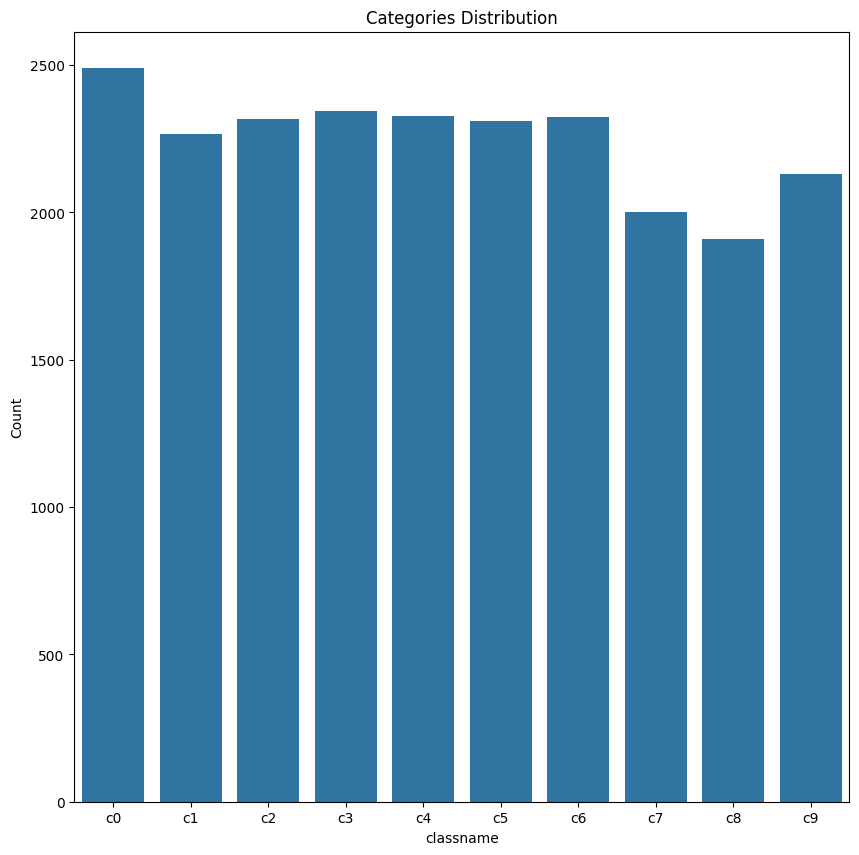

In [9]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

In [10]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
drivers_id

driver_id  Counts
0       p021    1237
1       p022    1233
2       p024    1226
3       p026    1196
4       p016    1078
5       p066    1034
6       p049    1011
7       p051     920
8       p014     876
9       p015     875
10      p035     848
11      p047     835
12      p081     823
13      p012     823
14      p064     820
15      p075     814
16      p061     809
17      p056     794
18      p050     790
19      p052     740
20      p002     725
21      p045     724
22      p039     651
23      p041     605
24      p042     591
25      p072     346

<Figure size 2000x2000 with 0 Axes>

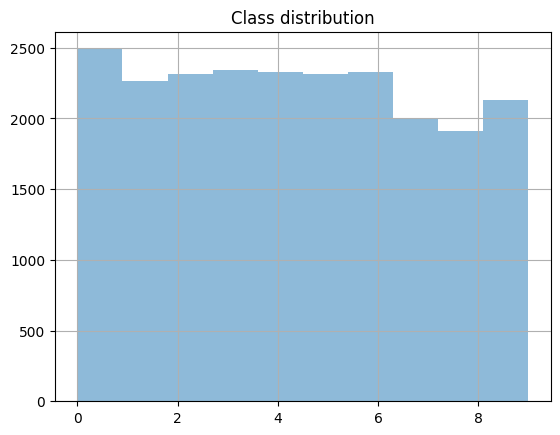

In [11]:
# Plotting class distribution
dataset['class_type'] = dataset['classname'].str.extract('(\d)',expand=False).astype(float)
plt.figure(figsize = (20,20))
dataset.hist('class_type', alpha=0.5, layout=(1,1), bins=10)
plt.title('Class distribution')
plt.show()

In [12]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

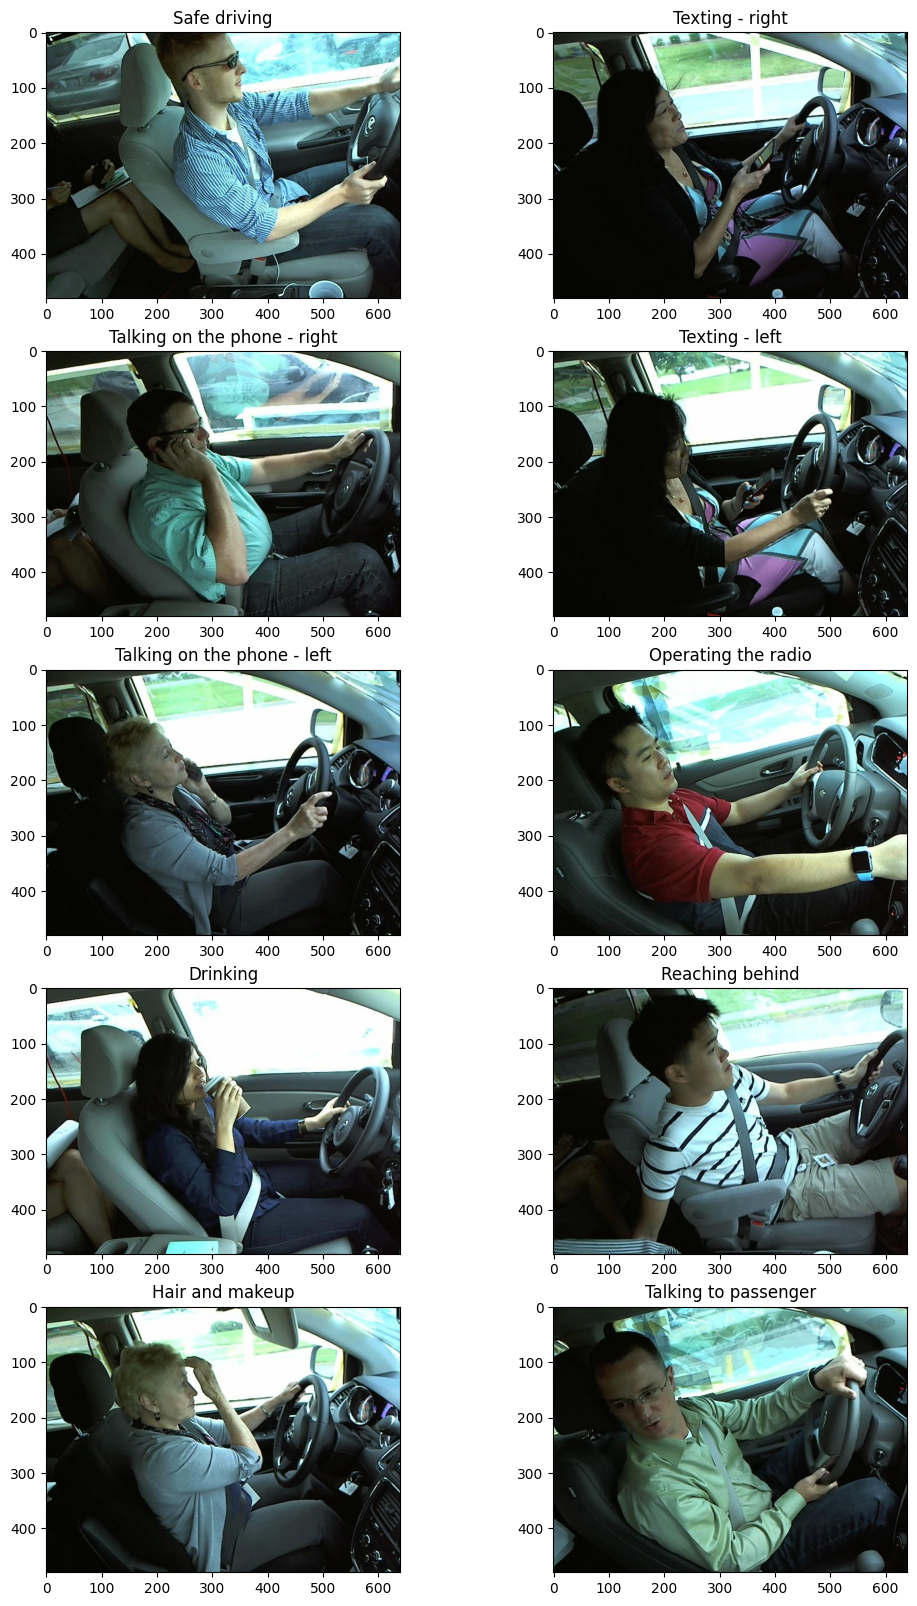

In [13]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = 'imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5,2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [14]:
# Data Loading Function
def load_data(img_rows, img_cols):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = to_categorical(labels, NUMBER_CLASSES)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1, img_rows, img_cols, color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1, img_rows, img_cols, color_type)
    
    return x_train, x_test, y_train, y_test

In [15]:
# Load Data
x_train, x_test, y_train, y_test = load_data(img_rows, img_cols)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0
*******files: ['imgs\\train\\c0\\img_100026.jpg', 'imgs\\train\\c0\\img_10003.jpg', 'imgs\\train\\c0\\img_100050.jpg', 'imgs\\train\\c0\\img_100074.jpg', 'imgs\\train\\c0\\img_10012.jpg', 'imgs\\train\\c0\\img_100145.jpg', 'imgs\\train\\c0\\img_100191.jpg', 'imgs\\train\\c0\\img_100257.jpg', 'imgs\\train\\c0\\img_100312.jpg', 'imgs\\train\\c0\\img_100337.jpg', 'imgs\\train\\c0\\img_100456.jpg', 'imgs\\train\\c0\\img_1005.jpg', 'imgs\\train\\c0\\img_10053.jpg', 'imgs\\train\\c0\\img_100542.jpg', 'imgs\\train\\c0\\img_100598.jpg', 'imgs\\train\\c0\\img_100605.jpg', 'imgs\\train\\c0\\img_100656.jpg', 'imgs\\train\\c0\\img_100665.jpg', 'imgs\\train\\c0\\img_100796.jpg', 'imgs\\train\\c0\\img_100824.jpg', 'imgs\\train\\c0\\img_100828.jpg', 'imgs\\train\\c0\\img_10092.jpg', 'imgs\\train\\c0\\img_100922.jpg', 'imgs\\train\\c0\\img_101015.jpg', 'imgs\\train\\c0\\img_101032.jpg', 'imgs\\train\\c0\\img_101091.jpg', 'imgs\\train\\c0\\img_101113.jpg', 'imgs\\train\\c0\\img_101

 10%|█         | 1/10 [00:03<00:29,  3.24s/it]

------- imgs\train\c0\img_94863.jpg
------- imgs\train\c0\img_94879.jpg
------- imgs\train\c0\img_94962.jpg
------- imgs\train\c0\img_94969.jpg
------- imgs\train\c0\img_95047.jpg
------- imgs\train\c0\img_95056.jpg
------- imgs\train\c0\img_95086.jpg
------- imgs\train\c0\img_95169.jpg
------- imgs\train\c0\img_9520.jpg
------- imgs\train\c0\img_95245.jpg
------- imgs\train\c0\img_95252.jpg
------- imgs\train\c0\img_95285.jpg
------- imgs\train\c0\img_95306.jpg
------- imgs\train\c0\img_9532.jpg
------- imgs\train\c0\img_95339.jpg
------- imgs\train\c0\img_95355.jpg
------- imgs\train\c0\img_95525.jpg
------- imgs\train\c0\img_95572.jpg
------- imgs\train\c0\img_95596.jpg
------- imgs\train\c0\img_95630.jpg
------- imgs\train\c0\img_95649.jpg
------- imgs\train\c0\img_95667.jpg
------- imgs\train\c0\img_95698.jpg
------- imgs\train\c0\img_957.jpg
------- imgs\train\c0\img_95728.jpg
------- imgs\train\c0\img_95735.jpg
------- imgs\train\c0\img_95760.jpg
------- imgs\train\c0\img_95774.

 20%|██        | 2/10 [00:06<00:24,  3.02s/it]

------- imgs\train\c1\img_95825.jpg
------- imgs\train\c1\img_95843.jpg
------- imgs\train\c1\img_9587.jpg
------- imgs\train\c1\img_95912.jpg
------- imgs\train\c1\img_95967.jpg
------- imgs\train\c1\img_95970.jpg
------- imgs\train\c1\img_95996.jpg
------- imgs\train\c1\img_95997.jpg
------- imgs\train\c1\img_96038.jpg
------- imgs\train\c1\img_96093.jpg
------- imgs\train\c1\img_9610.jpg
------- imgs\train\c1\img_96129.jpg
------- imgs\train\c1\img_96140.jpg
------- imgs\train\c1\img_96164.jpg
------- imgs\train\c1\img_96218.jpg
------- imgs\train\c1\img_96239.jpg
------- imgs\train\c1\img_96296.jpg
------- imgs\train\c1\img_96349.jpg
------- imgs\train\c1\img_96357.jpg
------- imgs\train\c1\img_96369.jpg
------- imgs\train\c1\img_96397.jpg
------- imgs\train\c1\img_96416.jpg
------- imgs\train\c1\img_96421.jpg
------- imgs\train\c1\img_96466.jpg
------- imgs\train\c1\img_96472.jpg
------- imgs\train\c1\img_9655.jpg
------- imgs\train\c1\img_9656.jpg
------- imgs\train\c1\img_96569.

 30%|███       | 3/10 [00:08<00:20,  2.95s/it]

------- imgs\train\c2\img_93839.jpg
------- imgs\train\c2\img_9384.jpg
------- imgs\train\c2\img_93866.jpg
------- imgs\train\c2\img_93872.jpg
------- imgs\train\c2\img_93998.jpg
------- imgs\train\c2\img_94.jpg
------- imgs\train\c2\img_94066.jpg
------- imgs\train\c2\img_94108.jpg
------- imgs\train\c2\img_94128.jpg
------- imgs\train\c2\img_94142.jpg
------- imgs\train\c2\img_9415.jpg
------- imgs\train\c2\img_94170.jpg
------- imgs\train\c2\img_9418.jpg
------- imgs\train\c2\img_94192.jpg
------- imgs\train\c2\img_94253.jpg
------- imgs\train\c2\img_94307.jpg
------- imgs\train\c2\img_94415.jpg
------- imgs\train\c2\img_94456.jpg
------- imgs\train\c2\img_94500.jpg
------- imgs\train\c2\img_94598.jpg
------- imgs\train\c2\img_94604.jpg
------- imgs\train\c2\img_94657.jpg
------- imgs\train\c2\img_94677.jpg
------- imgs\train\c2\img_94769.jpg
------- imgs\train\c2\img_94777.jpg
------- imgs\train\c2\img_94862.jpg
------- imgs\train\c2\img_9493.jpg
------- imgs\train\c2\img_94932.jpg

 40%|████      | 4/10 [00:11<00:17,  2.93s/it]

------- imgs\train\c3\img_94344.jpg
------- imgs\train\c3\img_94379.jpg
------- imgs\train\c3\img_94488.jpg
------- imgs\train\c3\img_94549.jpg
------- imgs\train\c3\img_94562.jpg
------- imgs\train\c3\img_94643.jpg
------- imgs\train\c3\img_94651.jpg
------- imgs\train\c3\img_94691.jpg
------- imgs\train\c3\img_94703.jpg
------- imgs\train\c3\img_94722.jpg
------- imgs\train\c3\img_94726.jpg
------- imgs\train\c3\img_94752.jpg
------- imgs\train\c3\img_94753.jpg
------- imgs\train\c3\img_9480.jpg
------- imgs\train\c3\img_94860.jpg
------- imgs\train\c3\img_94970.jpg
------- imgs\train\c3\img_94976.jpg
------- imgs\train\c3\img_9498.jpg
------- imgs\train\c3\img_95067.jpg
------- imgs\train\c3\img_95218.jpg
------- imgs\train\c3\img_95248.jpg
------- imgs\train\c3\img_95266.jpg
------- imgs\train\c3\img_9529.jpg
------- imgs\train\c3\img_95358.jpg
------- imgs\train\c3\img_95370.jpg
------- imgs\train\c3\img_95385.jpg
------- imgs\train\c3\img_95389.jpg
------- imgs\train\c3\img_95458

 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

------- imgs\train\c4\img_99121.jpg
------- imgs\train\c4\img_99264.jpg
------- imgs\train\c4\img_99317.jpg
------- imgs\train\c4\img_99325.jpg
------- imgs\train\c4\img_99363.jpg
------- imgs\train\c4\img_99370.jpg
------- imgs\train\c4\img_99434.jpg
------- imgs\train\c4\img_99470.jpg
------- imgs\train\c4\img_99540.jpg
------- imgs\train\c4\img_99544.jpg
------- imgs\train\c4\img_99575.jpg
------- imgs\train\c4\img_99580.jpg
------- imgs\train\c4\img_99583.jpg
------- imgs\train\c4\img_99622.jpg
------- imgs\train\c4\img_99624.jpg
------- imgs\train\c4\img_9963.jpg
------- imgs\train\c4\img_99645.jpg
------- imgs\train\c4\img_99662.jpg
------- imgs\train\c4\img_99762.jpg
------- imgs\train\c4\img_99804.jpg
------- imgs\train\c4\img_99805.jpg
------- imgs\train\c4\img_99811.jpg
------- imgs\train\c4\img_99814.jpg
------- imgs\train\c4\img_99821.jpg
------- imgs\train\c4\img_99871.jpg
------- imgs\train\c4\img_99931.jpg
------- imgs\train\c4\img_99977.jpg
------- imgs\train\c4\img_999

 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

------- imgs\train\c5\img_9369.jpg
------- imgs\train\c5\img_93740.jpg
------- imgs\train\c5\img_93769.jpg
------- imgs\train\c5\img_93827.jpg
------- imgs\train\c5\img_93847.jpg
------- imgs\train\c5\img_93857.jpg
------- imgs\train\c5\img_93949.jpg
------- imgs\train\c5\img_93990.jpg
------- imgs\train\c5\img_9405.jpg
------- imgs\train\c5\img_94051.jpg
------- imgs\train\c5\img_94080.jpg
------- imgs\train\c5\img_94088.jpg
------- imgs\train\c5\img_94090.jpg
------- imgs\train\c5\img_9410.jpg
------- imgs\train\c5\img_94140.jpg
------- imgs\train\c5\img_94160.jpg
------- imgs\train\c5\img_94164.jpg
------- imgs\train\c5\img_94196.jpg
------- imgs\train\c5\img_9430.jpg
------- imgs\train\c5\img_94304.jpg
------- imgs\train\c5\img_94334.jpg
------- imgs\train\c5\img_94382.jpg
------- imgs\train\c5\img_94470.jpg
------- imgs\train\c5\img_94498.jpg
------- imgs\train\c5\img_94547.jpg
------- imgs\train\c5\img_94559.jpg
------- imgs\train\c5\img_94594.jpg
------- imgs\train\c5\img_94608.

 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

------- imgs\train\c6\img_97213.jpg
------- imgs\train\c6\img_97240.jpg
------- imgs\train\c6\img_97294.jpg
------- imgs\train\c6\img_97302.jpg
------- imgs\train\c6\img_97341.jpg
------- imgs\train\c6\img_97404.jpg
------- imgs\train\c6\img_9741.jpg
------- imgs\train\c6\img_97428.jpg
------- imgs\train\c6\img_97539.jpg
------- imgs\train\c6\img_97620.jpg
------- imgs\train\c6\img_97649.jpg
------- imgs\train\c6\img_97674.jpg
------- imgs\train\c6\img_97687.jpg
------- imgs\train\c6\img_97688.jpg
------- imgs\train\c6\img_97713.jpg
------- imgs\train\c6\img_97788.jpg
------- imgs\train\c6\img_97825.jpg
------- imgs\train\c6\img_9783.jpg
------- imgs\train\c6\img_97885.jpg
------- imgs\train\c6\img_97909.jpg
------- imgs\train\c6\img_97989.jpg
------- imgs\train\c6\img_98118.jpg
------- imgs\train\c6\img_98214.jpg
------- imgs\train\c6\img_98248.jpg
------- imgs\train\c6\img_98251.jpg
------- imgs\train\c6\img_98294.jpg
------- imgs\train\c6\img_98318.jpg
------- imgs\train\c6\img_9840

 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

------- imgs\train\c7\img_96775.jpg
------- imgs\train\c7\img_96779.jpg
------- imgs\train\c7\img_96845.jpg
------- imgs\train\c7\img_96891.jpg
------- imgs\train\c7\img_96912.jpg
------- imgs\train\c7\img_96939.jpg
------- imgs\train\c7\img_96957.jpg
------- imgs\train\c7\img_96999.jpg
------- imgs\train\c7\img_97022.jpg
------- imgs\train\c7\img_97242.jpg
------- imgs\train\c7\img_9763.jpg
------- imgs\train\c7\img_97631.jpg
------- imgs\train\c7\img_9768.jpg
------- imgs\train\c7\img_97794.jpg
------- imgs\train\c7\img_97803.jpg
------- imgs\train\c7\img_97804.jpg
------- imgs\train\c7\img_97818.jpg
------- imgs\train\c7\img_9782.jpg
------- imgs\train\c7\img_97852.jpg
------- imgs\train\c7\img_9787.jpg
------- imgs\train\c7\img_97874.jpg
------- imgs\train\c7\img_97950.jpg
------- imgs\train\c7\img_98101.jpg
------- imgs\train\c7\img_9827.jpg
------- imgs\train\c7\img_98312.jpg
------- imgs\train\c7\img_98315.jpg
------- imgs\train\c7\img_98350.jpg
------- imgs\train\c7\img_98455.j

 90%|█████████ | 9/10 [00:26<00:02,  2.84s/it]

------- imgs\train\c8\img_94016.jpg
------- imgs\train\c8\img_94081.jpg
------- imgs\train\c8\img_94215.jpg
------- imgs\train\c8\img_94297.jpg
------- imgs\train\c8\img_94309.jpg
------- imgs\train\c8\img_94317.jpg
------- imgs\train\c8\img_94386.jpg
------- imgs\train\c8\img_94413.jpg
------- imgs\train\c8\img_94442.jpg
------- imgs\train\c8\img_94489.jpg
------- imgs\train\c8\img_9449.jpg
------- imgs\train\c8\img_94503.jpg
------- imgs\train\c8\img_94544.jpg
------- imgs\train\c8\img_94576.jpg
------- imgs\train\c8\img_9459.jpg
------- imgs\train\c8\img_94630.jpg
------- imgs\train\c8\img_9464.jpg
------- imgs\train\c8\img_94652.jpg
------- imgs\train\c8\img_9471.jpg
------- imgs\train\c8\img_94715.jpg
------- imgs\train\c8\img_94897.jpg
------- imgs\train\c8\img_94975.jpg
------- imgs\train\c8\img_9499.jpg
------- imgs\train\c8\img_95038.jpg
------- imgs\train\c8\img_95140.jpg
------- imgs\train\c8\img_95148.jpg
------- imgs\train\c8\img_95193.jpg
------- imgs\train\c8\img_95215.j

100%|██████████| 10/10 [00:29<00:00,  2.90s/it]

------- imgs\train\c9\img_99740.jpg
------- imgs\train\c9\img_99761.jpg
------- imgs\train\c9\img_99801.jpg
------- imgs\train\c9\img_99927.jpg
------- imgs\train\c9\img_9993.jpg
------- imgs\train\c9\img_99949.jpg
Data Loaded in 29.006038427352905 second


In [16]:
# Function to evaluate the model and return metrics
def evaluate_model_metrics(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return accuracy, precision, recall, f1

# # Load models, evaluate metrics, and collect results
def load_and_evaluate_models(model_paths, img_rows, img_cols):
    metrics_table = []

    for fold_no, model_path in enumerate(model_paths, start=1):
        print(f"Evaluating Fold {fold_no}...")

        # Load the model
        model = load_model(model_path)

        # Evaluate on test data
        accuracy, precision, recall, f1 = evaluate_model_metrics(model, x_test, y_test)
        metrics_table.append([fold_no, accuracy, precision, recall, f1])

    return metrics_table

### Build CNN Model

In [17]:
# Define constants
NUMBER_CLASSES = 10
img_rows, img_cols, color_type = 64, 64, 3  
batch_size = 32
nb_epoch = 30
learning_rate = 0.0001
momentum = 0.9


def create_model():
    model = Sequential()

    # First convolution block
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(img_rows, img_cols, color_type), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolution block
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolution block
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fourth convolution block
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model



In [18]:
# Data Loading Function
def load_data(img_rows, img_cols):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = to_categorical(labels, NUMBER_CLASSES)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1, img_rows, img_cols, color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1, img_rows, img_cols, color_type)
    
    return x_train, x_test, y_train, y_test

### Evaluation Functions

In [19]:
# Evaluation Function
def evaluate_model(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=activity_map.values(), yticklabels=activity_map.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Function to plot training history
def plot_training_history(history, fold_no):
    
    # Accuracy plot
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy (Fold {fold_no})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    # Loss plot
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss (Fold {fold_no})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

#  Table Display of Results
def print_table(metrics_table):
    table = PrettyTable()
    table.field_names = ["Fold", "Accuracy", "Precision", "Recall", "F1 Score"]

    for row in metrics_table:
        table.add_row([row[0], f"{row[1]:.4f}", f"{row[2]:.4f}", f"{row[3]:.4f}", f"{row[4]:.4f}"])

    print("\nEvaluation Metrics Table for Each Fold:")
    print(table)

### K-Fold Cross Validation

In [20]:
# Model Training with Cross-validation
def train_with_kfold(x_train, y_train, x_test, y_test, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_no = 1
    best_model = None
    best_accuracy = 0

    for train_idx, val_idx in kfold.split(x_train, y_train):
        print(f"Training Fold {fold_no}/{k}...")
        
        x_train_fold, x_val_fold = x_train[train_idx], x_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        model = create_model()
        
        # Callbacks
        checkpointer = ModelCheckpoint(f'saved_models/model_fold_{fold_no}.keras', save_best_only=True, verbose=1)
        es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)
        callbacks = [checkpointer, es]
        
        # Train the model
        history = model.fit(x_train_fold, y_train_fold, epochs=nb_epoch, batch_size=batch_size, validation_data=(x_val_fold, y_val_fold), callbacks=callbacks, verbose=1)
        
        # Evaluate on validation data
        val_loss, val_accuracy = model.evaluate(x_val_fold, y_val_fold, verbose=0)
        print(f"Validation Accuracy for Fold {fold_no}: {val_accuracy:.2f}")
        
        # Save the best model
        if val_accuracy > best_accuracy:
            best_model = model
            best_accuracy = val_accuracy
        
        # Plot training history
        plot_training_history(history, fold_no)
        
        fold_no += 1

    print(f"Best Validation Accuracy: {best_accuracy:.2f}")
    return best_model



### Evaluation with Best Model

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0
*******files: ['imgs\\train\\c0\\img_100026.jpg', 'imgs\\train\\c0\\img_10003.jpg', 'imgs\\train\\c0\\img_100050.jpg', 'imgs\\train\\c0\\img_100074.jpg', 'imgs\\train\\c0\\img_10012.jpg', 'imgs\\train\\c0\\img_100145.jpg', 'imgs\\train\\c0\\img_100191.jpg', 'imgs\\train\\c0\\img_100257.jpg', 'imgs\\train\\c0\\img_100312.jpg', 'imgs\\train\\c0\\img_100337.jpg', 'imgs\\train\\c0\\img_100456.jpg', 'imgs\\train\\c0\\img_1005.jpg', 'imgs\\train\\c0\\img_10053.jpg', 'imgs\\train\\c0\\img_100542.jpg', 'imgs\\train\\c0\\img_100598.jpg', 'imgs\\train\\c0\\img_100605.jpg', 'imgs\\train\\c0\\img_100656.jpg', 'imgs\\train\\c0\\img_100665.jpg', 'imgs\\train\\c0\\img_100796.jpg', 'imgs\\train\\c0\\img_100824.jpg', 'imgs\\train\\c0\\img_100828.jpg', 'imgs\\train\\c0\\img_10092.jpg', 'imgs\\train\\c0\\img_100922.jpg', 'imgs\\train\\c0\\img_101015.jpg', 'imgs\\train\\c0\\img_101032.jpg', 'imgs\\train\\c0\\img_101091.jpg', 'imgs\\train\\c0\\img_101113.jpg', 'imgs\\train\\c0\\img_101

 10%|█         | 1/10 [00:05<00:51,  5.70s/it]

------- imgs\train\c0\img_97714.jpg
------- imgs\train\c0\img_97738.jpg
------- imgs\train\c0\img_97751.jpg
------- imgs\train\c0\img_97758.jpg
------- imgs\train\c0\img_97780.jpg
------- imgs\train\c0\img_97783.jpg
------- imgs\train\c0\img_97789.jpg
------- imgs\train\c0\img_97792.jpg
------- imgs\train\c0\img_97807.jpg
------- imgs\train\c0\img_97987.jpg
------- imgs\train\c0\img_98046.jpg
------- imgs\train\c0\img_98068.jpg
------- imgs\train\c0\img_981.jpg
------- imgs\train\c0\img_98115.jpg
------- imgs\train\c0\img_98129.jpg
------- imgs\train\c0\img_98143.jpg
------- imgs\train\c0\img_98271.jpg
------- imgs\train\c0\img_98275.jpg
------- imgs\train\c0\img_98402.jpg
------- imgs\train\c0\img_98415.jpg
------- imgs\train\c0\img_98442.jpg
------- imgs\train\c0\img_98454.jpg
------- imgs\train\c0\img_98494.jpg
------- imgs\train\c0\img_98505.jpg
------- imgs\train\c0\img_98733.jpg
------- imgs\train\c0\img_98853.jpg
------- imgs\train\c0\img_98899.jpg
------- imgs\train\c0\img_9891

 20%|██        | 2/10 [00:10<00:43,  5.46s/it]

------- imgs\train\c1\img_98739.jpg
------- imgs\train\c1\img_98746.jpg
------- imgs\train\c1\img_98787.jpg
------- imgs\train\c1\img_98916.jpg
------- imgs\train\c1\img_98924.jpg
------- imgs\train\c1\img_98954.jpg
------- imgs\train\c1\img_98983.jpg
------- imgs\train\c1\img_99036.jpg
------- imgs\train\c1\img_99084.jpg
------- imgs\train\c1\img_99119.jpg
------- imgs\train\c1\img_9912.jpg
------- imgs\train\c1\img_99147.jpg
------- imgs\train\c1\img_9915.jpg
------- imgs\train\c1\img_99182.jpg
------- imgs\train\c1\img_99183.jpg
------- imgs\train\c1\img_99248.jpg
------- imgs\train\c1\img_99283.jpg
------- imgs\train\c1\img_99294.jpg
------- imgs\train\c1\img_99337.jpg
------- imgs\train\c1\img_99361.jpg
------- imgs\train\c1\img_99379.jpg
------- imgs\train\c1\img_99429.jpg
------- imgs\train\c1\img_99452.jpg
------- imgs\train\c1\img_99455.jpg
------- imgs\train\c1\img_99479.jpg
------- imgs\train\c1\img_9956.jpg
------- imgs\train\c1\img_99573.jpg
------- imgs\train\c1\img_99633

 30%|███       | 3/10 [00:16<00:38,  5.44s/it]

------- imgs\train\c2\img_97132.jpg
------- imgs\train\c2\img_9719.jpg
------- imgs\train\c2\img_97201.jpg
------- imgs\train\c2\img_97226.jpg
------- imgs\train\c2\img_97243.jpg
------- imgs\train\c2\img_97326.jpg
------- imgs\train\c2\img_97380.jpg
------- imgs\train\c2\img_97440.jpg
------- imgs\train\c2\img_97465.jpg
------- imgs\train\c2\img_97473.jpg
------- imgs\train\c2\img_97487.jpg
------- imgs\train\c2\img_97502.jpg
------- imgs\train\c2\img_97520.jpg
------- imgs\train\c2\img_97535.jpg
------- imgs\train\c2\img_97538.jpg
------- imgs\train\c2\img_97629.jpg
------- imgs\train\c2\img_97655.jpg
------- imgs\train\c2\img_97672.jpg
------- imgs\train\c2\img_9779.jpg
------- imgs\train\c2\img_97820.jpg
------- imgs\train\c2\img_97843.jpg
------- imgs\train\c2\img_97878.jpg
------- imgs\train\c2\img_97880.jpg
------- imgs\train\c2\img_97903.jpg
------- imgs\train\c2\img_97977.jpg
------- imgs\train\c2\img_98148.jpg
------- imgs\train\c2\img_98158.jpg
------- imgs\train\c2\img_9816

 40%|████      | 4/10 [00:22<00:33,  5.66s/it]

------- imgs\train\c3\img_98867.jpg
------- imgs\train\c3\img_98876.jpg
------- imgs\train\c3\img_98881.jpg
------- imgs\train\c3\img_98935.jpg
------- imgs\train\c3\img_98946.jpg
------- imgs\train\c3\img_99007.jpg
------- imgs\train\c3\img_99080.jpg
------- imgs\train\c3\img_99118.jpg
------- imgs\train\c3\img_99184.jpg
------- imgs\train\c3\img_99188.jpg
------- imgs\train\c3\img_99341.jpg
------- imgs\train\c3\img_99374.jpg
------- imgs\train\c3\img_99406.jpg
------- imgs\train\c3\img_99413.jpg
------- imgs\train\c3\img_99480.jpg
------- imgs\train\c3\img_99551.jpg
------- imgs\train\c3\img_99703.jpg
------- imgs\train\c3\img_99712.jpg
------- imgs\train\c3\img_99727.jpg
------- imgs\train\c3\img_99754.jpg
------- imgs\train\c3\img_99813.jpg
------- imgs\train\c3\img_99848.jpg
------- imgs\train\c3\img_99870.jpg
------- imgs\train\c3\img_99896.jpg
------- imgs\train\c3\img_99906.jpg
------- imgs\train\c3\img_99947.jpg
------- imgs\train\c3\img_99963.jpg
Loading directory c4
*******

 50%|█████     | 5/10 [00:29<00:30,  6.08s/it]

------- imgs\train\c4\img_99544.jpg
------- imgs\train\c4\img_99575.jpg
------- imgs\train\c4\img_99580.jpg
------- imgs\train\c4\img_99583.jpg
------- imgs\train\c4\img_99622.jpg
------- imgs\train\c4\img_99624.jpg
------- imgs\train\c4\img_9963.jpg
------- imgs\train\c4\img_99645.jpg
------- imgs\train\c4\img_99662.jpg
------- imgs\train\c4\img_99762.jpg
------- imgs\train\c4\img_99804.jpg
------- imgs\train\c4\img_99805.jpg
------- imgs\train\c4\img_99811.jpg
------- imgs\train\c4\img_99814.jpg
------- imgs\train\c4\img_99821.jpg
------- imgs\train\c4\img_99871.jpg
------- imgs\train\c4\img_99931.jpg
------- imgs\train\c4\img_99977.jpg
------- imgs\train\c4\img_99992.jpg
Loading directory c5
*******files: ['imgs\\train\\c5\\img_10000.jpg', 'imgs\\train\\c5\\img_100027.jpg', 'imgs\\train\\c5\\img_100061.jpg', 'imgs\\train\\c5\\img_100121.jpg', 'imgs\\train\\c5\\img_100136.jpg', 'imgs\\train\\c5\\img_100152.jpg', 'imgs\\train\\c5\\img_100215.jpg', 'imgs\\train\\c5\\img_100270.jpg', 'i

 60%|██████    | 6/10 [00:35<00:24,  6.25s/it]

------- imgs\train\c5\img_99827.jpg
------- imgs\train\c5\img_99955.jpg
------- imgs\train\c5\img_99965.jpg
------- imgs\train\c5\img_99978.jpg
Loading directory c6
*******files: ['imgs\\train\\c6\\img_0.jpg', 'imgs\\train\\c6\\img_100036.jpg', 'imgs\\train\\c6\\img_100065.jpg', 'imgs\\train\\c6\\img_100109.jpg', 'imgs\\train\\c6\\img_100116.jpg', 'imgs\\train\\c6\\img_100144.jpg', 'imgs\\train\\c6\\img_100181.jpg', 'imgs\\train\\c6\\img_100200.jpg', 'imgs\\train\\c6\\img_100232.jpg', 'imgs\\train\\c6\\img_100241.jpg', 'imgs\\train\\c6\\img_100251.jpg', 'imgs\\train\\c6\\img_100256.jpg', 'imgs\\train\\c6\\img_100396.jpg', 'imgs\\train\\c6\\img_10046.jpg', 'imgs\\train\\c6\\img_100528.jpg', 'imgs\\train\\c6\\img_100540.jpg', 'imgs\\train\\c6\\img_100548.jpg', 'imgs\\train\\c6\\img_100565.jpg', 'imgs\\train\\c6\\img_100568.jpg', 'imgs\\train\\c6\\img_100634.jpg', 'imgs\\train\\c6\\img_100640.jpg', 'imgs\\train\\c6\\img_100643.jpg', 'imgs\\train\\c6\\img_100664.jpg', 'imgs\\train\\c6\\img

 70%|███████   | 7/10 [00:41<00:18,  6.05s/it]

------- imgs\train\c6\img_98642.jpg
------- imgs\train\c6\img_98782.jpg
------- imgs\train\c6\img_98797.jpg
------- imgs\train\c6\img_98836.jpg
------- imgs\train\c6\img_98963.jpg
------- imgs\train\c6\img_98977.jpg
------- imgs\train\c6\img_99067.jpg
------- imgs\train\c6\img_99081.jpg
------- imgs\train\c6\img_99116.jpg
------- imgs\train\c6\img_99135.jpg
------- imgs\train\c6\img_99173.jpg
------- imgs\train\c6\img_99175.jpg
------- imgs\train\c6\img_99256.jpg
------- imgs\train\c6\img_99261.jpg
------- imgs\train\c6\img_99407.jpg
------- imgs\train\c6\img_99439.jpg
------- imgs\train\c6\img_99454.jpg
------- imgs\train\c6\img_99458.jpg
------- imgs\train\c6\img_99459.jpg
------- imgs\train\c6\img_99520.jpg
------- imgs\train\c6\img_99618.jpg
------- imgs\train\c6\img_99637.jpg
------- imgs\train\c6\img_99644.jpg
------- imgs\train\c6\img_99649.jpg
------- imgs\train\c6\img_99682.jpg
------- imgs\train\c6\img_99697.jpg
------- imgs\train\c6\img_9973.jpg
------- imgs\train\c6\img_997

 80%|████████  | 8/10 [00:46<00:11,  5.80s/it]

------- imgs\train\c7\img_98713.jpg
------- imgs\train\c7\img_98738.jpg
------- imgs\train\c7\img_98768.jpg
------- imgs\train\c7\img_9882.jpg
------- imgs\train\c7\img_98837.jpg
------- imgs\train\c7\img_98839.jpg
------- imgs\train\c7\img_98843.jpg
------- imgs\train\c7\img_98870.jpg
------- imgs\train\c7\img_98878.jpg
------- imgs\train\c7\img_98890.jpg
------- imgs\train\c7\img_98904.jpg
------- imgs\train\c7\img_9892.jpg
------- imgs\train\c7\img_98947.jpg
------- imgs\train\c7\img_9897.jpg
------- imgs\train\c7\img_99020.jpg
------- imgs\train\c7\img_99110.jpg
------- imgs\train\c7\img_99268.jpg
------- imgs\train\c7\img_99288.jpg
------- imgs\train\c7\img_99484.jpg
------- imgs\train\c7\img_995.jpg
------- imgs\train\c7\img_99683.jpg
------- imgs\train\c7\img_99736.jpg
------- imgs\train\c7\img_99743.jpg
------- imgs\train\c7\img_99747.jpg
------- imgs\train\c7\img_99784.jpg
------- imgs\train\c7\img_99844.jpg
------- imgs\train\c7\img_99851.jpg
------- imgs\train\c7\img_99915.j

 90%|█████████ | 9/10 [00:51<00:05,  5.41s/it]

------- imgs\train\c8\img_99577.jpg
------- imgs\train\c8\img_99596.jpg
------- imgs\train\c8\img_99693.jpg
------- imgs\train\c8\img_99709.jpg
------- imgs\train\c8\img_99796.jpg
------- imgs\train\c8\img_99798.jpg
------- imgs\train\c8\img_99812.jpg
------- imgs\train\c8\img_99816.jpg
------- imgs\train\c8\img_99840.jpg
------- imgs\train\c8\img_99869.jpg
------- imgs\train\c8\img_99945.jpg
------- imgs\train\c8\img_99982.jpg
Loading directory c9
*******files: ['imgs\\train\\c9\\img_100090.jpg', 'imgs\\train\\c9\\img_100100.jpg', 'imgs\\train\\c9\\img_100190.jpg', 'imgs\\train\\c9\\img_100286.jpg', 'imgs\\train\\c9\\img_100294.jpg', 'imgs\\train\\c9\\img_100299.jpg', 'imgs\\train\\c9\\img_100327.jpg', 'imgs\\train\\c9\\img_100379.jpg', 'imgs\\train\\c9\\img_100394.jpg', 'imgs\\train\\c9\\img_100428.jpg', 'imgs\\train\\c9\\img_100429.jpg', 'imgs\\train\\c9\\img_100499.jpg', 'imgs\\train\\c9\\img_100589.jpg', 'imgs\\train\\c9\\img_100697.jpg', 'imgs\\train\\c9\\img_10090.jpg', 'imgs\\t

100%|██████████| 10/10 [00:56<00:00,  5.63s/it]

------- imgs\train\c9\img_96877.jpg
------- imgs\train\c9\img_96905.jpg
------- imgs\train\c9\img_97105.jpg
------- imgs\train\c9\img_97177.jpg
------- imgs\train\c9\img_97229.jpg
------- imgs\train\c9\img_97274.jpg
------- imgs\train\c9\img_97287.jpg
------- imgs\train\c9\img_97490.jpg
------- imgs\train\c9\img_97500.jpg
------- imgs\train\c9\img_97580.jpg
------- imgs\train\c9\img_97581.jpg
------- imgs\train\c9\img_97605.jpg
------- imgs\train\c9\img_97749.jpg
------- imgs\train\c9\img_9777.jpg
------- imgs\train\c9\img_97801.jpg
------- imgs\train\c9\img_97863.jpg
------- imgs\train\c9\img_97868.jpg
------- imgs\train\c9\img_97889.jpg
------- imgs\train\c9\img_97943.jpg
------- imgs\train\c9\img_97981.jpg
------- imgs\train\c9\img_97983.jpg
------- imgs\train\c9\img_97999.jpg
------- imgs\train\c9\img_98054.jpg
------- imgs\train\c9\img_98100.jpg
------- imgs\train\c9\img_98182.jpg
------- imgs\train\c9\img_98205.jpg
------- imgs\train\c9\img_98296.jpg
------- imgs\train\c9\img_983

Training Fold 1/5...
Epoch 1/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4214 - loss: 1.9952
Epoch 1: val_loss improved from inf to 0.22747, saving model to saved_models/model_fold_1.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 62s 131ms/step - accuracy: 0.4218 - loss: 1.9935 - val_accuracy: 0.9565 - val_loss: 0.2275
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9254 - loss: 0.2556
Epoch 2: val_loss improved from 0.22747 to 0.07668, saving model to saved_models/model_fold_1.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 194s 430ms/step - accuracy: 0.9254 - loss: 0.2555 - val_accuracy: 0.9836 - val_loss: 0.0767
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9712 - loss: 0.0912
Epoch 3: val_loss improved from 0.07668 to 0.05873, saving model to saved_models/model_fold_1.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 1745s 4s/step - accuracy: 0.9712 - loss: 0.0912 - val_accuracy: 0.9836 - val_loss: 0.0587
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accura

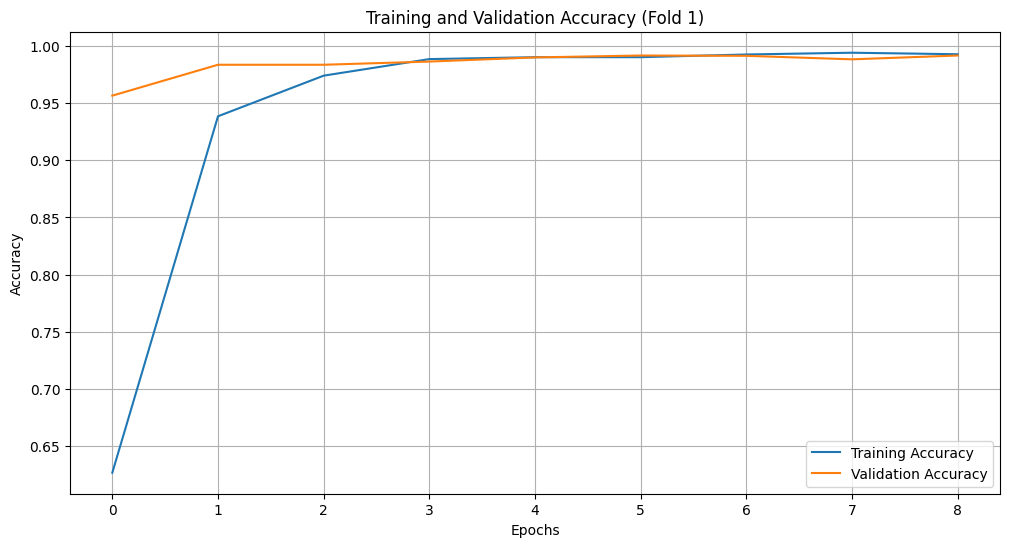

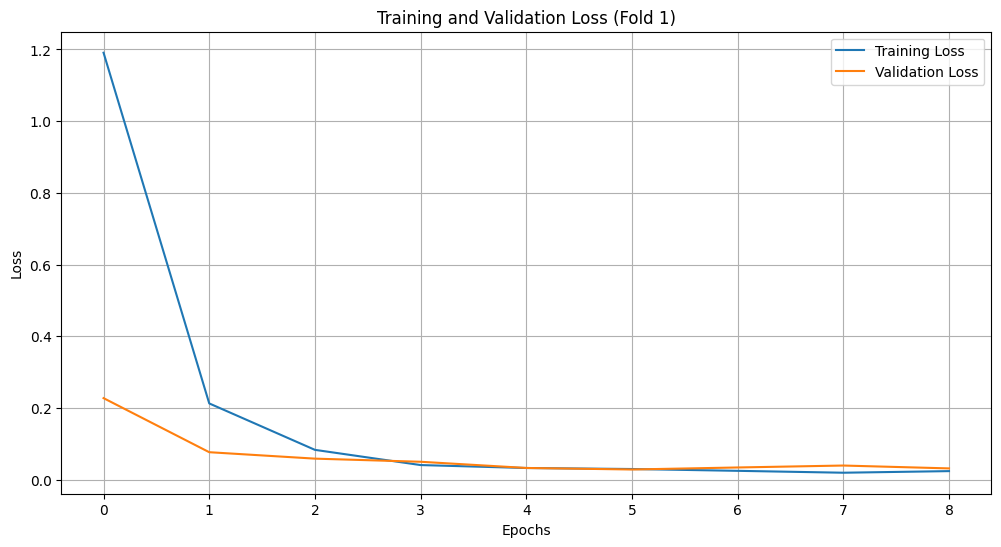

Training Fold 2/5...
Epoch 1/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4236 - loss: 1.9846
Epoch 1: val_loss improved from inf to 0.22115, saving model to saved_models/model_fold_2.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 53s 109ms/step - accuracy: 0.4241 - loss: 1.9828 - val_accuracy: 0.9599 - val_loss: 0.2211
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9258 - loss: 0.2596
Epoch 2: val_loss improved from 0.22115 to 0.07786, saving model to saved_models/model_fold_2.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - accuracy: 0.9258 - loss: 0.2595 - val_accuracy: 0.9841 - val_loss: 0.0779
Epoch 3/30
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9722 - loss: 0.0965
Epoch 3: val_loss improved from 0.07786 to 0.06028, saving model to saved_models/model_fold_2.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - accuracy: 0.9722 - loss: 0.0964 - val_accuracy: 0.9847 - val_loss: 0.0603
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - acc

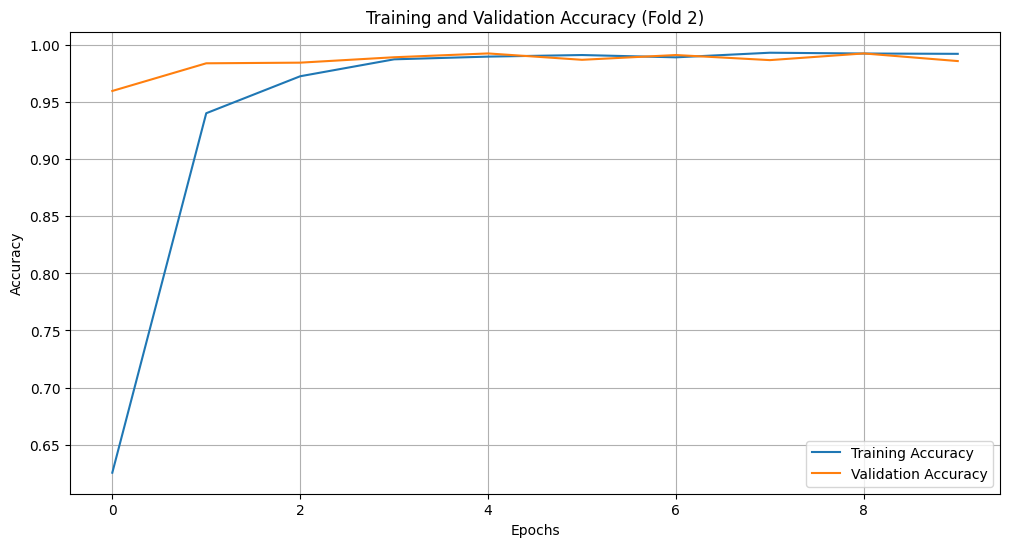

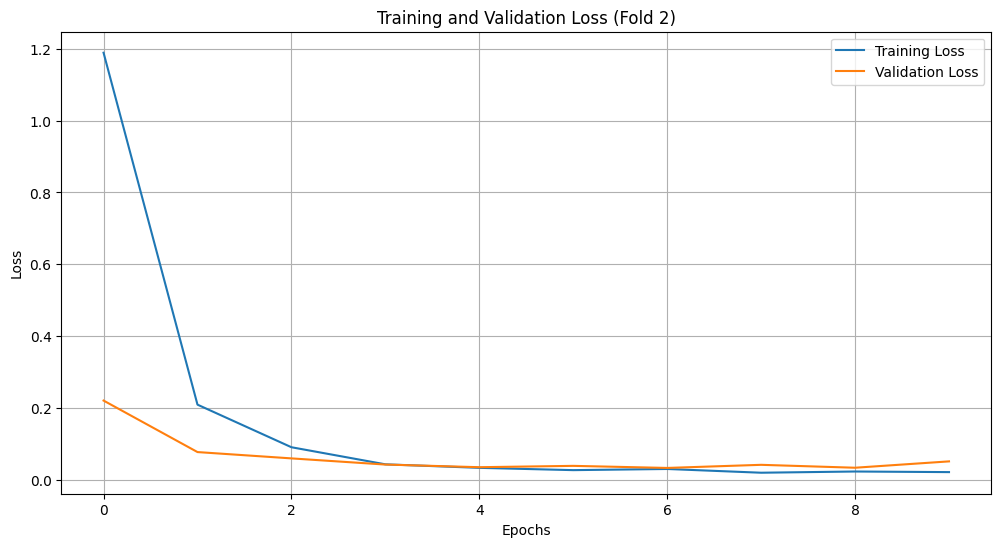

Training Fold 3/5...
Epoch 1/30
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.4338 - loss: 1.9441
Epoch 1: val_loss improved from inf to 0.21185, saving model to saved_models/model_fold_3.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 61s 126ms/step - accuracy: 0.4347 - loss: 1.9406 - val_accuracy: 0.9601 - val_loss: 0.2119
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9284 - loss: 0.2415
Epoch 2: val_loss improved from 0.21185 to 0.10848, saving model to saved_models/model_fold_3.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 55s 123ms/step - accuracy: 0.9285 - loss: 0.2415 - val_accuracy: 0.9699 - val_loss: 0.1085
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9705 - loss: 0.0999
Epoch 3: val_loss improved from 0.10848 to 0.03903, saving model to saved_models/model_fold_3.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 55s 123ms/step - accuracy: 0.9705 - loss: 0.0998 - val_accuracy: 0.9908 - val_loss: 0.0390
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - acc

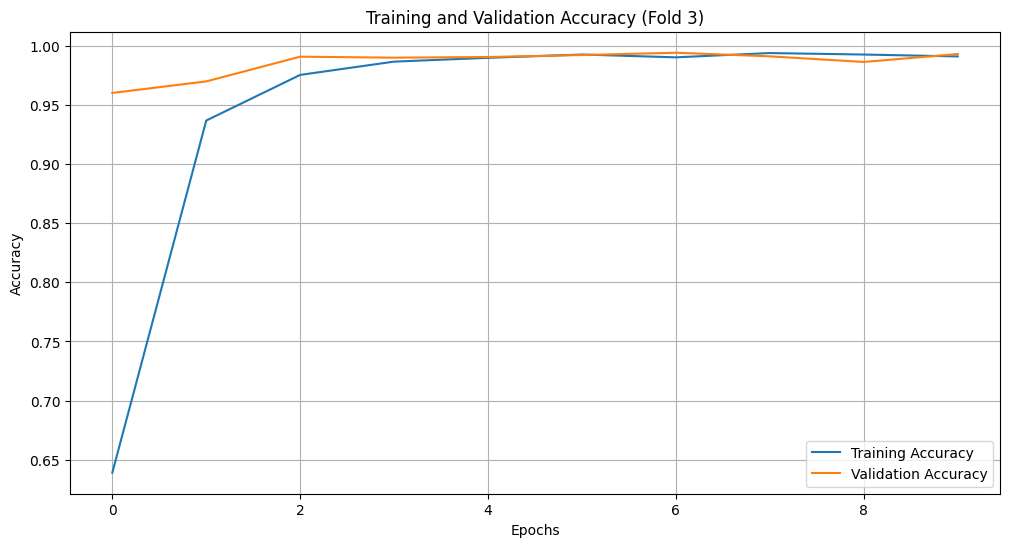

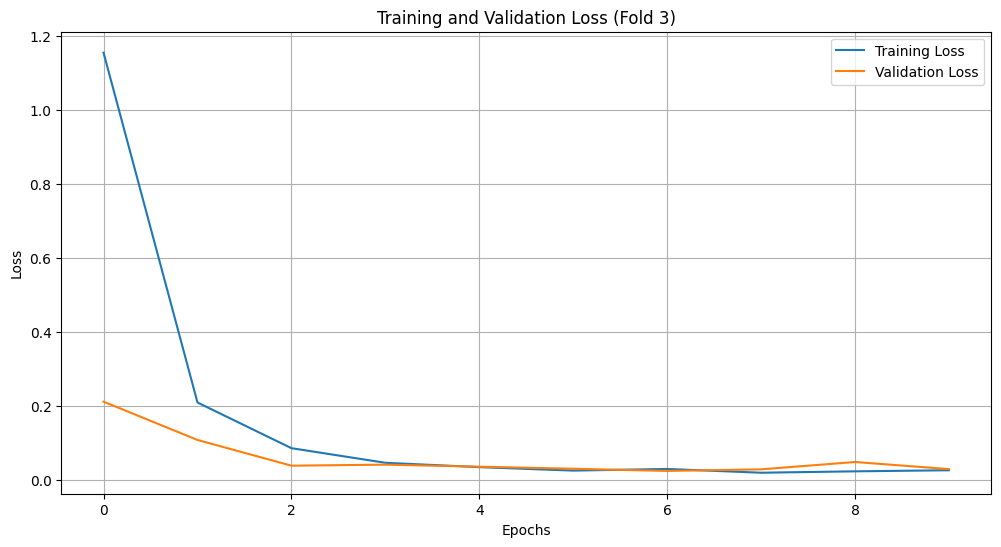

Training Fold 4/5...
Epoch 1/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.4231 - loss: 2.0048
Epoch 1: val_loss improved from inf to 0.24502, saving model to saved_models/model_fold_4.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 59s 122ms/step - accuracy: 0.4235 - loss: 2.0031 - val_accuracy: 0.9518 - val_loss: 0.2450
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9079 - loss: 0.3042
Epoch 2: val_loss improved from 0.24502 to 0.08166, saving model to saved_models/model_fold_4.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 76s 109ms/step - accuracy: 0.9079 - loss: 0.3040 - val_accuracy: 0.9802 - val_loss: 0.0817
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9718 - loss: 0.1022
Epoch 3: val_loss improved from 0.08166 to 0.06132, saving model to saved_models/model_fold_4.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 57s 127ms/step - accuracy: 0.9718 - loss: 0.1022 - val_accuracy: 0.9838 - val_loss: 0.0613
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - acc

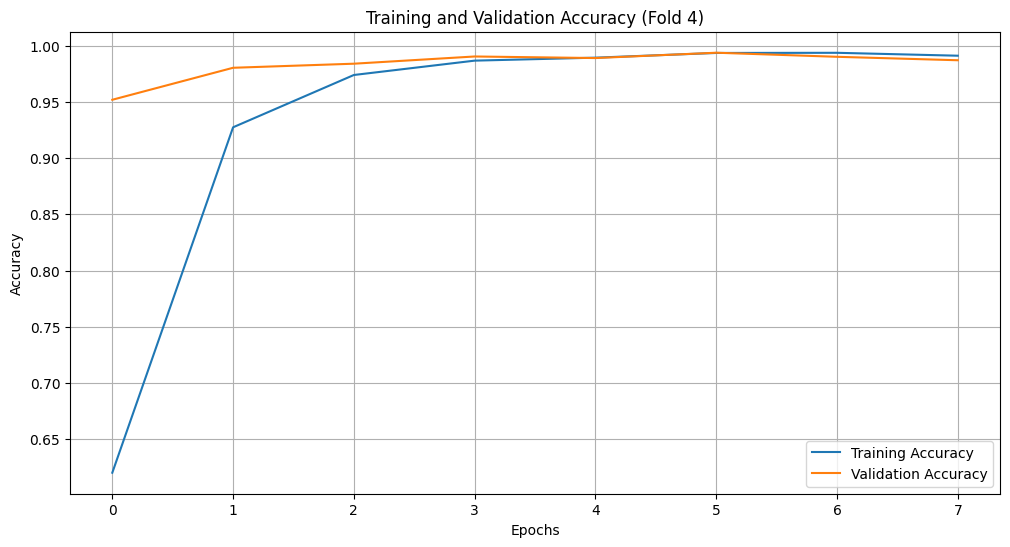

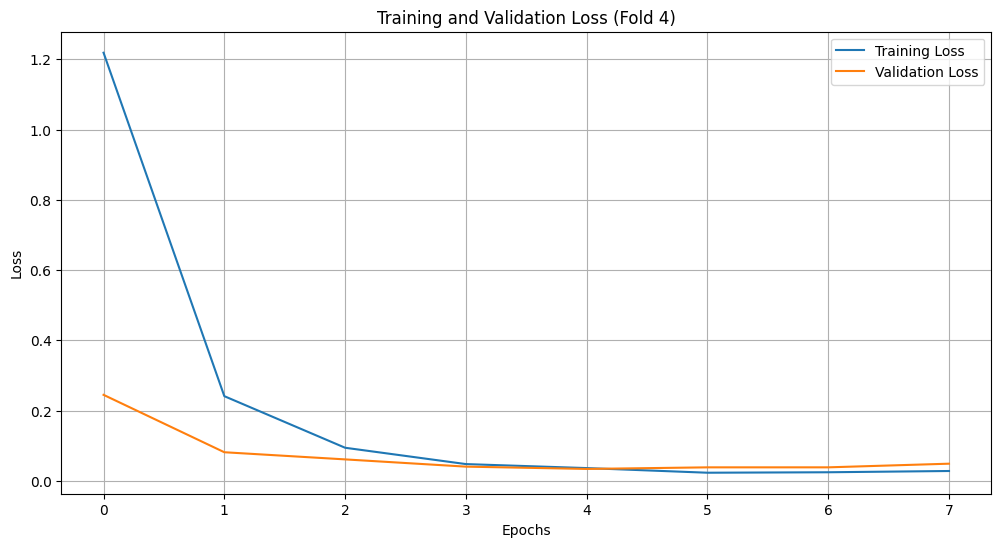

Training Fold 5/5...
Epoch 1/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.4060 - loss: 2.0679
Epoch 1: val_loss improved from inf to 0.32402, saving model to saved_models/model_fold_5.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 365s 793ms/step - accuracy: 0.4064 - loss: 2.0661 - val_accuracy: 0.9236 - val_loss: 0.3240
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9116 - loss: 0.2868
Epoch 2: val_loss improved from 0.32402 to 0.10020, saving model to saved_models/model_fold_5.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 55s 121ms/step - accuracy: 0.9117 - loss: 0.2867 - val_accuracy: 0.9738 - val_loss: 0.1002
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9681 - loss: 0.1051
Epoch 3: val_loss improved from 0.10020 to 0.05467, saving model to saved_models/model_fold_5.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 57s 128ms/step - accuracy: 0.9682 - loss: 0.1051 - val_accuracy: 0.9844 - val_loss: 0.0547
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - ac

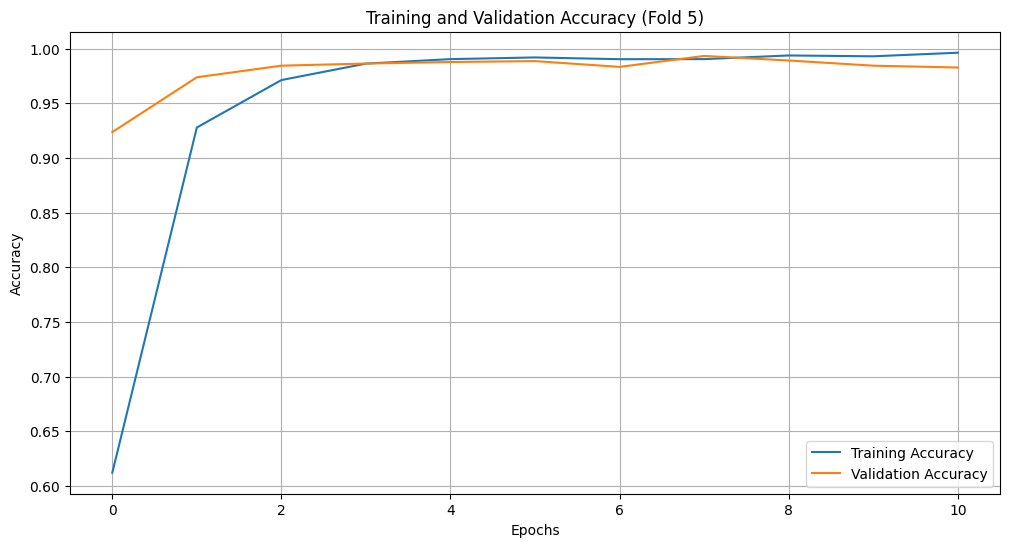

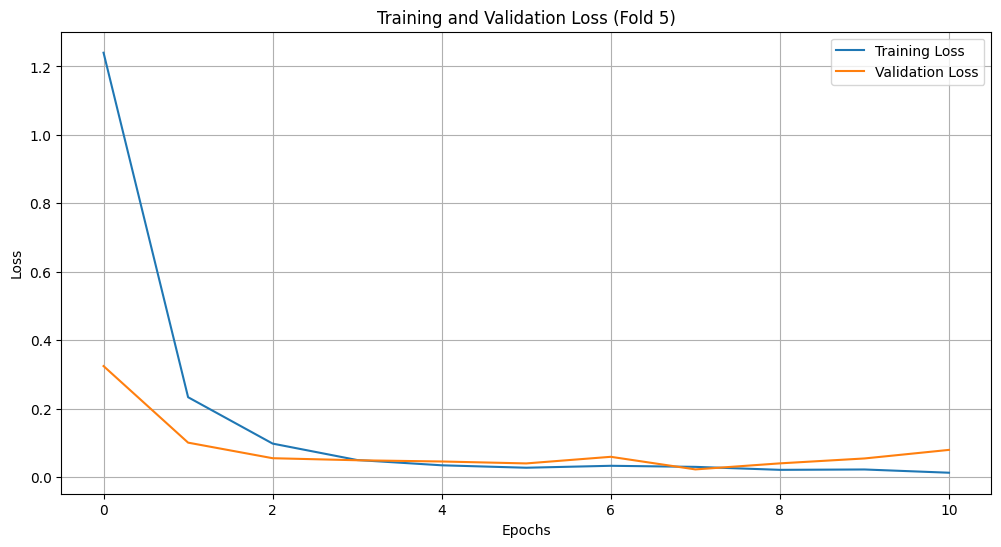

Best Validation Accuracy: 0.99

Evaluating Best Model on Test Set...
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
Accuracy: 0.9922
Precision: 0.9923
Recall: 0.9922
F1 Score: 0.9922

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       463
           1       1.00      0.98      0.99       500
           2       1.00      0.99      1.00       480
           3       0.97      1.00      0.99       491
           4       0.99      1.00      0.99       466
           5       1.00      0.99      0.99       466
           6       0.99      1.00      1.00       457
           7       1.00      1.00      1.00       377
           8       1.00      0.97      0.99       390
           9       0.98      0.99      0.99       395

    accuracy                           0.99      4485
   macro avg       0.99      0.99      0.99      4485
weighted avg       0.99      0.99      0.99      4485


Confusion Matrix:
[[458   0   0   5   

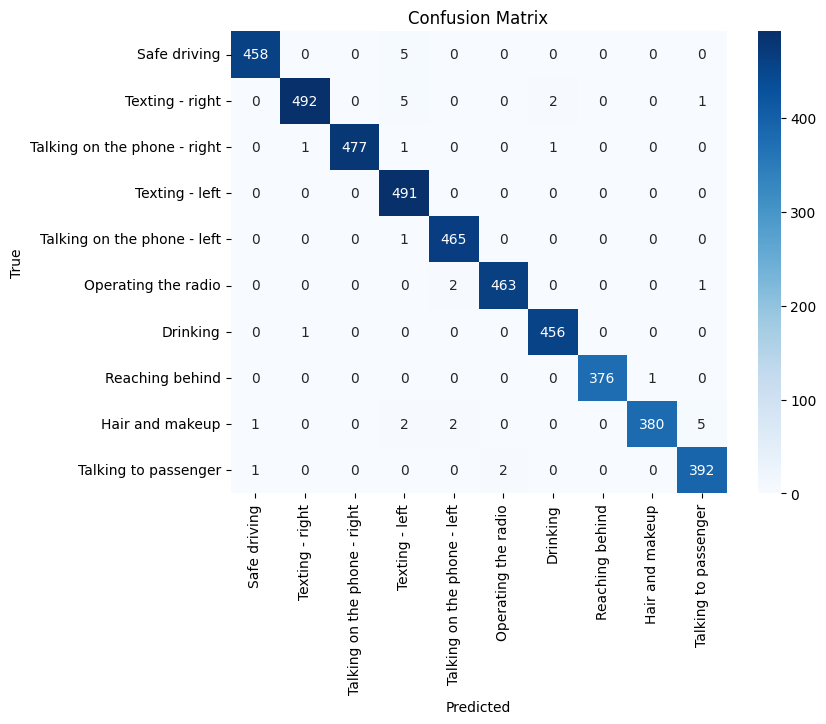

Evaluating Fold 1...
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
Evaluating Fold 2...
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step
Evaluating Fold 3...
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step
Evaluating Fold 4...
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step
Evaluating Fold 5...
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step

Evaluation Metrics Table for Each Fold:
+------+----------+-----------+--------+----------+
| Fold | Accuracy | Precision | Recall | F1 Score |
+------+----------+-----------+--------+----------+
|  1   |  0.9904  |   0.9906  | 0.9904 |  0.9904  |
|  2   |  0.9940  |   0.9940  | 0.9940 |  0.9940  |
|  3   |  0.9924  |   0.9925  | 0.9924 |  0.9924  |
|  4   |  0.9920  |   0.9920  | 0.9920 |  0.9920  |
|  5   |  0.9931  |   0.9931  | 0.9931 |  0.9931  |
+------+----------+-----------+--------+----------+


In [21]:
# Load Data
x_train, x_test, y_train, y_test = load_data(img_rows, img_cols)   

# Train and Evaluate Model
best_model = train_with_kfold(x_train, y_train, x_test, y_test, k=5)

# Final Evaluation on Test Set
print("\nEvaluating Best Model on Test Set...")
evaluate_model(best_model, x_test, y_test)

# Define paths to your saved models
model_paths = [
    "saved_models/model_fold_1.keras",
    "saved_models/model_fold_2.keras",
    "saved_models/model_fold_3.keras",
    "saved_models/model_fold_4.keras",
    "saved_models/model_fold_5.keras"
]

# Define image dimensions 
img_rows, img_cols = 48, 48  

# Evaluate metrics
metrics_table = load_and_evaluate_models(model_paths, img_rows, img_cols)
# Display Fancy Table
print_table(metrics_table)
